In [1]:
import itertools
import json
import nilearn
import os
import nilearn
import nibabel as nib
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn

from pathlib import Path
from os import listdir as ls
from os.path import basename as bname
from os.path import dirname as dname
from os.path import expanduser as xpu
from os.path import join as pjoin
from pandas import DataFrame as df
from tqdm import tqdm
from typing import Sequence, Union
from collections.abc import Iterable

from nilearn import masking
from nilearn.connectome import ConnectivityMeasure
from nilearn.image import concat_imgs, iter_img, mean_img
from nilearn.input_data import NiftiMasker, NiftiMapsMasker, NiftiLabelsMasker

from nilearn import plotting
import nilearn.decoding
from nilearn.input_data import NiftiMasker
from nilearn.plotting import plot_stat_map, plot_anat, plot_img, plot_epi
from nilearn.glm.first_level import FirstLevelModel, make_first_level_design_matrix  

import cimaqprep
import loadutils as lu
import sniffbytes as snif
import scanzip as szip

from sklearn.feature_selection import f_classif
from sklearn.model_selection import KFold

/home/fnadeau/myenv/lib/python3.7/site-packages/nilearn/datasets/__init__.py:89: FutureWarning: Fetchers from the nilearn.datasets module will be updated in version 0.9 to return python strings instead of bytes and Pandas dataframes instead of Numpy arrays.
  "Numpy arrays.", FutureWarning)


fetching in-scan events: 100%|████████████████| 95/95 [00:00<00:00, 6108.15it/s]
computing trial durations: 120it [00:00, 7253.34it/s]
fetching out-scan behavioural data: 100%|█████| 95/95 [00:00<00:00, 4974.70it/s]
finding correct spatial answers: 117it [00:00, 426.44it/s]
computing spatial accuracy: 117it [00:00, 7514.26it/s]
fetching in-scan events: 100%|████████████████| 95/95 [00:00<00:00, 3072.51it/s]
computing trial durations: 120it [00:00, 7652.79it/s]
fetching out-scan behavioural data: 100%|████| 95/95 [00:00<00:00, 14790.60it/s]
finding correct spatial answers: 117it [00:00, 405.71it/s]
computing spatial accuracy: 117it [00:00, 7354.79it/s]
resampling fMRI image to events lenght: 100%|█| 120/120 [00:13<00:00,  8.83it/s]


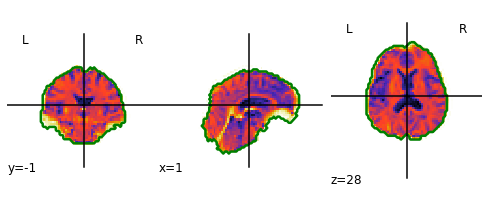

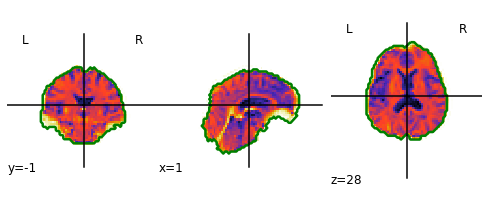

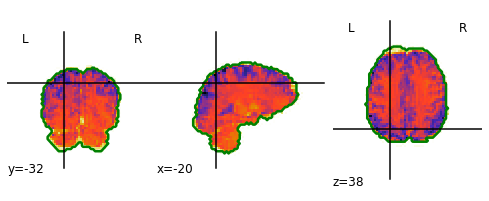

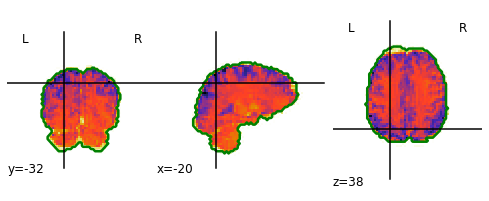

In [16]:
# from notebook.services.config import ConfigManager
# cmanager = ConfigManager()
# cmanager.update('notebook', {'ExecuteTime': {
#     'display_absolute_timestamps': False,
#     'relative_timing_update_period': 5,
#     'template': {
#         'executed': 'started ${start_time}, finished in ${duration}',
#     }
# }})

paths_of_interest = {'cimaq_nov_dir':xpu('~/../../data/simexp/DATA/cimaq_20190901'),
                     'cimaq_mar_dir':xpu('~/../../data/simexp/DATA/cimaq_03-19'),
                     'events_dir':xpu('~/../../data/simexp/DATA/cimaq_corrected_events/events'),
                     'behav_dir':xpu('~/../../data/simexp/DATA/cimaq_corrected_behavioural/behavioural')}
#                      'participants_path':xpu('~/../../data/simexp/DATA/cimaq_03-19/derivatives/CIMAQ_fmri_memory/data/participants/')}
import warnings
warnings.filterwarnings('ignore')
from os.path import expanduser as xpu
from cimaqprep.participant_data import participant_data
subject00, subject01 = participant_data(**paths_of_interest), participant_data(**paths_of_interest)

In [24]:
difumo64 = nilearn.datasets.fetch_atlas_difumo(dimension=64,
                                    resolution_mm=3,
                                    data_dir=xpu('~/../../data/neuromod/DATA/DiFuMo/'),
                                    resume=True,
                                    verbose=1)

In [339]:
def get_dictlearn_params(subject:object, **kwargs)->dict:
    mask_args00 = \
    {'allow_overlap': True,
     'smoothing_fwhm': 9,
     'standardize': False,
     'standardize_confounds': True,
     'high_variance_confounds': False,
     'detrend': False,
     'low_pass': None,
     'high_pass': None,
     't_r': subject00.t_r,
     'dtype': None,
     'resampling_target': 'maps',
#      'memory': Memory(location=None),
     'memory_level': 0,
     'verbose': 0}
#      'bg_img':mean_img(anat00)}
    dictlearn_params = \
        {'n_components': 10,
         'n_epochs': subject00.events.iloc[3:-1,:].shape[0],
         'alpha': 10,
         'reduction_ratio': 'auto',
#          'dict_init': None,
         'dict_init': difumo64.maps,
         'random_state': None,
         'batch_size': 2,
         'method': 'cd',
         'mask': subject00.masker.mask_img,
         'smoothing_fwhm':9,
#          'smoothing_fwhm': dict(nib.load(subject.mar_scans.anat[1][0]).header)['pixdim'][1]*3,
         'standardize': True,
         'detrend': False,
#          'low_pass': 0.21,
#          'low_pass':1.0,
#          'high_pass': 0.09,
         't_r': subject.t_r,
#          'target_affine': subject00.masker.target_affine,
#          'target_shape': subject00.masker.target_shape,
         'mask_strategy': 'epi',
#          'mask_args': None,
         'n_jobs': -2,
         'verbose': 0,
         'memory_level': 0,
         'mask_args':mask_args00}
    return dictlearn_params
dictlearn_params00=get_dictlearn_params(subject00)

In [ ]:
dictlearn00 = \
    nilearn.decomposition.DictLearning(**dictlearn_params00)
dictlearn00.fit(
#     imgs=subject00.cleaned_func,
    imgs=subject00.mar_scans.func[1][0],
    y=difumo64.labels,
    confounds=subject00.confounds,
    verbose=1)
#                 confounds=subject00.confounds)
nilearn.plotting.plot_prob_atlas(dictlearn00.components_img_,
                                 view_type='filled_contours')
#                           bg_img=mean_img(anat00))

In [ ]:
# Import Region Extractor algorithm from regions module
# threshold=0.5 indicates that we keep nominal of amount nonzero voxels across all
# maps, less the threshold means that more intense non-voxels will be survived.
from nilearn.regions import RegionExtractor

extractor = RegionExtractor(dictlearn00.components_img_,
                            threshold=0.5,
                            thresholding_strategy='ratio_n_voxels',
                            extractor='local_regions',
                            standardize=True,
                            min_region_size=1350)
# Just call fit() to process for regions extraction
extractor.fit()
# Extracted regions are stored in regions_img_
regions_extracted_img = extractor.regions_img_
# Each region index is stored in index_
regions_index = extractor.index_
# Total number of regions extracted
n_regions_extracted = regions_extracted_img.shape[-1]

# Visualization of region extraction results
title = ('%d regions are extracted from %d components.'
         '\nEach separate color of region indicates extracted region'
         % (n_regions_extracted, 8))
plotting.plot_prob_atlas(regions_extracted_img, view_type='filled_contours',
                         title=title)

In [315]:
anat_bg_mask = \
    nilearn.masking.compute_background_mask(data_imgs=concat_imgs(subject00.mar_scans.anat[1],
                                                                  auto_resample=True),
                                            border_size=2,
                                            connected=False,
                                            opening=True,
                                            target_affine=subject00.mar_epi_mask.affine,
                                            target_shape=subject00.mar_epi_mask.shape,
                                            memory=None,
                                            verbose=0)

In [316]:
anat00 = cimaqprep.resample_fmri_to_mask(concat_imgs(subject00.mar_scans.anat[1],
                                                     auto_resample=True),
                                         subject00.masker.mask_img)
# subject00.masker.mask_img == subject00.masker.mask_img_

Resampling fMRI volumes to epi mask: 100%|████████| 5/5 [00:05<00:00,  1.07s/it]


In [221]:
common_glm_matrix_params = \
    {'hrf_model':'spm + derivative',
     'drift_model':'cosine',
     'high_pass':0.09,
     'drift_order':1,
     'fir_delays':[0],
     'min_onset':0}
def make_glm_and_matrix(subject:object, **kwargs):
    # smoothing fwhm value criterion
    '''
    Source: http://jpeelle.net/mri/image_processing/smoothing.html
    One common rule of thumb is that, to render your data approximately normal,
    you should smooth with a Gaussian filter approximately three times the size of your voxel.
    If your voxel size is 3 x 3 x 3 mm, you would smooth with a 9 mm FWHM Gaussian filter.
    
    hrf_models available: # ['glover', 'spm', 'spm + derivative', 'spm + derivative + dispersion',
                             'glover + derivative', 'glover + derivative + dispersion', 'fir', None]
    '''

    from nilearn.glm.first_level import FirstLevelModel
    from nilearn.glm.first_level import make_first_level_design_matrix
    first_level_model = FirstLevelModel(t_r=subject.t_r,
                                          slice_time_ref=0.0,
                                          hrf_model='spm', 
                                          drift_model='cosine', # Can be 'polynomial', 'cosine' or None. Default='cosine'.
#                                           high_pass=0.09,
#                                           low_pass=0.21,
                                          drift_order=1, # Default
                                          fir_delays=[0], # Default
                                          min_onset=subject.events.onset[3],
                                          mask_img=subject.mar_epi_mask,
    #                                     target_affine=subject.mar_epi_mask.affine,
    #                                     target_shape=subject.mar_epi_mask.shape,
                                          smoothing_fwhm=dict(nib.load(subject.mar_scans.func[1][0]).header)['pixdim'][1]*3,
    #                                     memory=Memory(location=None),
                                          memory_level=1,
                                          standardize=True,
                                          signal_scaling=0,
                                          noise_model='ols',
                                          verbose=0, n_jobs=1,
                                          minimize_memory=False,
                                          subject_label=subject.sub_id[0])
#                                           **kwargs)
    # Create First Level Design Matrix
    fmri_design_matrix = \
        make_first_level_design_matrix(
    #         frame_times=train.dropna()[0],
            frame_times=subject.resampled_frame_times[3:-1],
    #         frame_times=np.arange(0, subject.frame_times.max(),
    #                                           subject.frame_times.max()/subject.events.shape[0]),
    #         events=subject.events[['onset','duration','trial_type']],
            events=subject.events.iloc[3:-1,:][['onset','duration','outcomes']].rename(columns=({'outcomes':'trial_type'})),
            hrf_model='spm',
            drift_model='cosine',
#             high_pass=0.01,
            drift_order=1,
            fir_delays=[0],
    #         add_regs=subject.resampled_confounds.fillna(0).values,
    #         add_reg_names=list(col.replace('.','_') for col in subject.resampled_confounds.columns),
            oversampling=1)
#             **kwargs)
    return first_level_model, fmri_design_matrix
first_level_model00, fmri_design_matrix00 = \
     make_glm_and_matrix(subject=subject00,**common_glm_matrix_params)

# Define desired contrasts names
new_contrast_names = list(str((itm[0],'- '+itm[1]))[1:-1].replace(
    "'",'').replace(',','') for itm in
     itertools.combinations([col for col in
                             list(fmri_design_matrix00.columns)
                             if 'drift' not in col],2))
new_contrast_names = [name.replace('.','_') for name in new_contrast_names]
contrast_params =\
{       'contrasts':list(fmri_design_matrix00.columns)[:4]+new_contrast_names,
#              +new_contrast_names,
        'title':None,
#         'bg_img':subject00.mar_epi_mask,
#         'bg_img':mean_img(difumo64.maps)
        'bg_img':subject00.mar_scans.anat[1][2],
        'threshold':3.09,
        'alpha':0.001,
        'cluster_threshold':3,
        'height_control':'fpr',
        'min_distance':3.0,
        'plot_type':'slice',
#         'display_mode':None,
#         'report_dims':(1600, 800)
}
# Model Fitting

first_level_model00.fit(run_imgs=concat_imgs(list(iter_img(subject00.cleaned_func))[3:-1]),
#                       events=subject00.events[['onset','duration','outcomes']].rename(columns={'outcomes':'trial_type'}),
#                       confounds=subject_data.confounds,
                      design_matrices=fmri_design_matrix00,
                      bins=fmri_design_matrix00.shape[0])
# report00 = first_level_model00.generate_report(**contrast_params)


FirstLevelModel(hrf_model='spm',
                mask_img=<nibabel.nifti1.Nifti1Image object at 0x7faeffea32d0>,
                min_onset=28.56, minimize_memory=False, noise_model='ols',
                signal_scaling=True, smoothing_fwhm=9.0,
                subject_label='sub-178101', t_r=2.499999)

In [288]:
contrasts00 = \
    [first_level_model00.compute_contrast(contrast_def=key,
                                     output_type='all')
     for key in tqdm(list(basic_contrasts00.keys()),
                     desc='computing contrasts')]

computing contrasts: 100%|██████████████████████| 15/15 [00:14<00:00,  1.03it/s]


In [164]:
import nilearn.decoding
from sklearn.model_selection import KFold
cv = KFold(n_splits=4)
searchlight = nilearn.decoding.SearchLight(mask_img=subject00.mar_epi_mask,
                                           process_mask_img=process_mask_img,
                                           radius=4.5,
                                           estimator='svc',
                                           n_jobs=1,
                                           scoring=None,
                                           cv=cv,
                                           verbose=1)

In [4]:
searchlight.fit(imgs=concat_imgs(list(iter_img(subject00.cleaned_func))[3:-1]),
                y=subject00.events.iloc[3:-1,:]['outcomes'].values.tolist())
# help(nilearn.decoding.SearchLight)

In [170]:
# F-score computation
from nilearn.input_data import NiftiMasker

# For decoding, standardizing is often very important
nifti_masker = NiftiMasker(mask_img=mask_img, sessions=None,
                           standardize=True)
#                            memory='nilearn_cache',
#                            memory_level=1)
fmri_masked = nifti_masker.fit_transform(concat_imgs(list(iter_img(subject00.cleaned_func))[3:-1]))

In [173]:


from sklearn.feature_selection import f_classif
f_values, p_values = f_classif(fmri_masked, y=subject00.events.iloc[3:-1,:]['outcomes'].values.tolist())
p_values = -np.log10(p_values)
p_values[p_values > 10] = 10
p_unmasked = nilearn.image.get_data(nifti_masker.inverse_transform(p_values))



In [197]:
subject00_resampled_anat = [(bname(anat_img), nilearn.image.resample_img(img=anat_img,
                                                       target_affine=subject00.mar_epi_mask.affine,
                                                       target_shape=subject00.mar_epi_mask.shape,
                                                       interpolation='continuous',
                                                       copy=True, order='F', clip=True,
                                                       fill_value=0,
                                                       force_resample=True))
  for anat_img in subject00.mar_scans.anat[1].tolist()]

In [5]:
from nilearn import image
from nilearn.image import new_img_like
mean_fmri = image.mean_img(concat_imgs(list(iter_img(subject00.cleaned_func))[3:-1]))

from nilearn.plotting import plot_stat_map, plot_img, show
searchlight_img = new_img_like(mean_fmri, searchlight.scores_)

# Because scores are not a zero-center test statistics, we cannot use
# plot_stat_map
[plot_img(img=searchlight_img,
          bg_img=anat_img[1],
          title="Searchlight {anat_img}".format(anat_img=anat_img[0]),
          display_mode="ortho",
#          cut_coords=[-9],
          vmin=.42,
          cmap='hot',
          threshold=.2,
          black_bg=True)
 for anat_img in subject00_resampled_anat]

# F_score results
# p_ma = np.ma.array(p_unmasked, mask=np.logical_not(process_mask))
# f_score_img = new_img_like(mean_fmri, p_ma)
# plot_stat_map(stat_map_img=f_score_img,
#               bg_img=subject00.mar_scans.anat[1][2],
#               title="F-scores", display_mode="ortho",
# #               cut_coords=[-9],
#               colorbar=True)

show()

In [6]:
# Make processing parallel
# /!\ As each thread will print its progress, n_jobs > 1 could mess up the
#     information output.

# Define the cross-validation scheme used for validation.
# Here we use a KFold cross-validation on the session, which corresponds to
# splitting the samples in 4 folds and make 4 runs using each fold as a test
# set once and the others as learning sets

# The radius is the one of the Searchlight sphere that will scan the volume

cv = KFold(n_splits=4)


searchlight = nilearn.decoding.SearchLight(
    mask_img,
    process_mask_img=None,
    radius=5.6, n_jobs=1,
    verbose=1, cv=cv)


In [7]:
rez=first_level_model00.__dict__['results_'][0][0.0]
dict(tuple((key, rez.__dict__[key]) for key in list(rez.__dict__.keys())))

In [110]:
from nilearn.input_data import NiftiMasker, NiftiLabelsMasker
labelsmasker00=NiftiLabelsMasker(labels_img=list(iter_img(difumo.maps))[0],
                                 labels=difumo.labels,
                                 background_label=0,
                                 mask_img=subject00.mar_epi_mask,
                                 smoothing_fwhm=9.0,
                                 standardize=True,
                                 standardize_confounds=True,
                                 high_variance_confounds=True,
                                 detrend=False,
                                 low_pass=0.21,
                                 high_pass=0.09,
                                 t_r=subject00.t_r,
                                 dtype=float,
                                 resampling_target='labels',
                                 memory_level=1,
                                 verbose=0,
                                 strategy='mean',
                                 reports=True)

In [9]:
labelsmasker00.fit_transform(imgs=subject00.cleaned_func,
                                                         confounds=None,
                                                         sample_mask=None)

In [176]:


# create masker to extract functional data within atlas parcels
masker = NiftiMapsMasker(maps_img=difumo.maps,
                         mask_img=subject00.mar_epi_mask,
                         standardize=True,
                         allow_overlap=True,
                         smoothing_fwhm=9.0,
                         standardize_confounds=True,
                         high_variance_confounds=True,
                         detrend=False,
                         low_pass=0.21,
                         high_pass=0.09,
                         t_r=subject00.t_r,
                         dtype=float,
                         resampling_target='maps',
                         memory_level=1,
                         verbose=0)
#                          memory='nilearn_cache')
connectome_measure = ConnectivityMeasure(kind='correlation')
masker.fit()
# extract time series from all subjects and concatenate them
time_series = masker.transform_single_imgs(imgs=subject00.cleaned_func)
#                                            sample_mask=subject00.masker)

In [177]:
# Has to be written between brackets to avoid dimensionality-related error
correlation_matrices = connectome_measure.fit([time_series])

In [178]:

# time_series = []
# for func, confounds in zip(subject00.cleaned_func, subject00.confounds):
#     time_series.append(masker.fit_transform(func, confounds=confounds))

# calculate correlation matrices across subjects and display
correlation_matrices = connectome_measure.fit_transform([time_series])

# Mean correlation matrix across 10 subjects can be grabbed like this,
# using connectome measure object
mean_correlation_matrix = connectome_measure.mean_

# grab center coordinates for probabilistic atlas
coordinates = nilearn.plotting.find_probabilistic_atlas_cut_coords(maps_img=difumo.maps)

In [10]:
# plot connectome with 85% edge strength in the connectivity
nilearn.plotting.plot_connectome(mean_correlation_matrix, coordinates,
                                 edge_threshold="85%",
                                 title='DiFuMo with {0} dimensions (probabilistic)'.format(64))
nilearn.plotting.show()

In [ ]:
NiftiMapsMasker(maps_img, mask_img=None, allow_overlap=True,
                smoothing_fwhm=None, standardize=False, standardize_confounds=True,
                high_variance_confounds=False, detrend=False, low_pass=None, high_pass=None,
                t_r=None, dtype=None,
                resampling_target='data', memory=Memory(location=None), memory_level=0, verbose=0)

In [ ]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# ConenctivityMeasure from Nilearn uses simple 'correlation' to compute
# connectivity matrices for all subjects in a list
connectome_measure = ConnectivityMeasure(kind='correlation')

# useful for plotting connectivity interactions on glass brain


# create masker to extract functional data within atlas parcels
masker = NiftiLabelsMasker(labels_img=yeo['thick_17'], standardize=True,
                           memory='nilearn_cache')

# extract time series from all subjects and concatenate them
time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, confounds=confounds))

# calculate correlation matrices across subjects and display
correlation_matrices = connectome_measure.fit_transform(time_series)

# Mean correlation matrix across 10 subjects can be grabbed like this,
# using connectome measure object
mean_correlation_matrix = connectome_measure.mean_

# grab center coordinates for atlas labels
coordinates = plotting.find_parcellation_cut_coords(labels_img=yeo['thick_17'])

# plot connectome with 80% edge strength in the connectivity
plotting.plot_connectome(mean_correlation_matrix, coordinates,
                         edge_threshold="80%",
                         title='Yeo Atlas 17 thick (func)')

In [12]:
# help(labelsmasker00.transform_single_imgs)
labelsmasker00.transform_single_imgs(difumo.maps)

In [104]:
labelsmasker00_4d_transform = labelsmasker00.transform_single_imgs(imgs=subject00.cleaned_func)


In [5]:
masked_imgs00 = subject00.masker.transform(imgs=subject00.cleaned_func)
masked_imgs01 = subject01.masker.transform(imgs=subject01.cleaned_func)
#                                confounds=subject00.confounds,
#                                sample_mask=nilearn.image.get_data(masker.mask_img_))

In [8]:
import sklearn
import sklearn.svm
from sklearn.feature_selection import SelectKBest
# help(SelectKBest)
import scipy
from scipy.fftpack import fft
# help(fft)

In [181]:
masked_func00 = nilearn.masking.apply_mask(imgs=subject00.cleaned_func,
                                         mask_img=subject00.masker.mask_img_,
                                         dtype='f',
                                         smoothing_fwhm=9.0,
                                         ensure_finite=True)

In [ ]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# ConenctivityMeasure from Nilearn uses simple 'correlation' to compute
# connectivity matrices for all subjects in a list
connectome_measure = ConnectivityMeasure(kind='correlation')

# useful for plotting connectivity interactions on glass brain
from nilearn import plotting

# create masker to extract functional data within atlas parcels
masker = NiftiLabelsMasker(labels_img=difumo.maps, standardize=True,
                           memory='nilearn_cache')

# extract time series from all subjects and concatenate them
time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, confounds=confounds))

# calculate correlation matrices across subjects and display
correlation_matrices = connectome_measure.fit_transform(time_series)

# Mean correlation matrix across 10 subjects can be grabbed like this,
# using connectome measure object
mean_correlation_matrix = connectome_measure.mean_

# grab center coordinates for atlas labels
coordinates = plotting.find_parcellation_cut_coords(labels_img=yeo['thick_17'])

# plot connectome with 80% edge strength in the connectivity
plotting.plot_connectome(mean_correlation_matrix, coordinates,
                         edge_threshold="80%",
                         title='Yeo Atlas 17 thick (func)')


In [23]:
report00.save_as_html(pjoin(xpu('~/'),str(subject00.sub_id[0])+'_'+str(subject00.sub_id[1])))

In [204]:
# Compute DiFuMo Atlas Masker
atlas_path=xpu('~/../../data/neuromod/DATA/DiFuMo/512/3mm/maps.nii.gz')
atlas_filename = nib.load(atlas_path)
labels = pd.read_csv(xpu('~/../../data/neuromod/DATA/DiFuMo/512/labels_512_dictionary.csv'))

# data,fmri_filenames=subject00, cleaned_fmri_imgs

from nilearn.input_data import NiftiLabelsMasker
masker00 = NiftiLabelsMasker(
#     labels_img=nilearn.image.mean_img(atlas_filename),
#                            labels_img=mean_img(concat_imgs(difumo['maps'])),
                           labels_img=mean_img(concat_imgs(difumo['maps'])),
                           labels=difumo['labels'],
                           background_label=0,
#                              mask_img=nilearn.image.mean_img(atlas_filename),
                           mask_img=subject00.mar_epi_mask,
                           smoothing_fwhm=9,
                           standardize=True,
                           standardize_confounds=True,
                           high_variance_confounds=True,
                           detrend=True,
                           low_pass=None, high_pass=None,
                           t_r=2.5, dtype=None,
                           resampling_target='data',
                           memory_level=1,
                           verbose=1, strategy='mean',
                             reports=True)


In [6]:
test02=df(subject00.resampled_frame_times,columns=['onset'])
test02[['duration', 'trial_type']]=tuple(zip(test02.onset.diff().dropna().unique().tolist()*test02.shape[0],
                                             subject00.events.outcomes.fillna('ctl')))
# test02['trial_type']=subject00.events.outcomes.fillna('ctl').values.tolist()
events_=test02

In [7]:
import numpy as np
import pandas as pd
from nilearn.glm.first_level import make_first_level_design_matrix

def make_design_matrices(fmri_img, events):
    design_matrices = []
    for idx, img in enumerate(fmri_img, start=1):
        # Build experimental paradigm
        n_scans = img.shape[-1]
#         events = pd.read_table(subject_data['events{}'.format(idx)])
        # Define the sampling times for the design matrix
        frame_times = np.arange(n_scans) * subject00.t_r
        # Build design matrix with the previously defined parameters
        design_matrix = make_first_level_design_matrix(
                frame_times,
                events,
                hrf_model='glover',
                drift_model='cosine',
    #             high_pass=high_pass,
                )
        # put the design matrices in a list
        design_matrices.append(design_matrix)
    return design_matrices
design_matrices = make_design_matrices(fmri_img=subject00.resampled_fmri_to_events.values,
                                       events=subject00.events[['onset','duration','outcomes']].rename(columns={'outcomes':'trial_type'}))

In [117]:
# tuple(zip([matrix.shape for matrix in design_matrices],
#           [img.shape for img in subject00.resampled_fmri_to_events.values]))
# len(subject00.resampled_fmri_to_events.values)


In [6]:
fit_model00_test=first_level_model00.fit(run_imgs=subject00.resampled_fmri_to_events.values,
                                         design_matrices=fmri_design_matrix00)

In [10]:
import itertools

new_contrast_names = list(str((itm[0],'- '+itm[1]))[1:-1].replace(
    "'",'').replace(',','') for itm in
     itertools.combinations([col for col in
                                                                             list(fmri_design_matrix00.columns)
                                                                             if 'drift' not in col],2))
for newname in new_contrast_names:
    basic_contrasts00[newname]=basic_contrasts00[]

In [24]:
difumo = nilearn.datasets.fetch_atlas_difumo(dimension=1024,
                                    resolution_mm=3,
                                    data_dir=xpu('~/../../data/neuromod/DATA/DiFuMo/'),
                                    resume=True,
                                    verbose=1)

In [41]:
# Compute DiFuMo Atlas Masker
atlas_path=xpu('~/../../data/neuromod/DATA/DiFuMo/512/3mm/maps.nii.gz')
atlas_filename = nib.load(atlas_path)
labels = pd.read_csv(xpu('~/../../data/neuromod/DATA/DiFuMo/512/labels_512_dictionary.csv'))


In [26]:
report00 = fit_model00.generate_report(**contrast_params)

In [27]:
report00_test = fit_model00_test.generate_report(**contrast_params)

In [28]:
# report00.save_as_html(xpu('~/+'+str(subject00.sub_id[0])+'_contrast_report.html'))

In [14]:
from nilearn.input_data import NiftiLabelsMasker
from nilearn.connectome import ConnectivityMeasure

# ConenctivityMeasure from Nilearn uses simple 'correlation' to compute
# connectivity matrices for all subjects in a list
connectome_measure = ConnectivityMeasure(kind='correlation')

# useful for plotting connectivity interactions on glass brain
from nilearn import plotting

# create masker to extract functional data within atlas parcels
masker = NiftiLabelsMasker(labels_img=difumo['thick_17'], standardize=True,
                           memory='nilearn_cache')

# extract time series from all subjects and concatenate them
time_series = []
for func, confounds in zip(data.func, data.confounds):
    time_series.append(masker.fit_transform(func, confounds=confounds))

# calculate correlation matrices across subjects and display
correlation_matrices = connectome_measure.fit_transform(time_series)

# Mean correlation matrix across 10 subjects can be grabbed like this,
# using connectome measure object
mean_correlation_matrix = connectome_measure.mean_

# grab center coordinates for atlas labels
coordinates = plotting.find_parcellation_cut_coords(labels_img=difumo['thick_17'])

# plot connectome with 80% edge strength in the connectivity
plotting.plot_connectome(mean_correlation_matrix, coordinates,
                         edge_threshold="80%",
                         title='difumo Atlas 17 thick (func)')

We can specify basic contrasts (to get beta maps).
We start by specifying canonical contrast that isolate design matrix columns.
We actually want more interesting contrasts. The simplest contrast
just makes the difference between the two main conditions.  We
define the two opposite versions to run one-tailed t-tests.  We also
define the effects of interest contrast, a 2-dimensional contrasts
spanning the two conditions.

In [ ]:
computed_contrasts=[fmri_glm.compute_contrast(
                         contrast_val, output_type='z_score')
                    for contrast_id, contrast_val in contrasts.items()]

In [15]:
import itertools
new_contrast_names = list(str((itm[0],'- '+itm[1]))[1:-1].replace(
    "'",'').replace(',','') for itm in
     itertools.combinations(names,2))
new_contrast_names
# basic_contrasts00[itm] = basic_contrasts00[itm.split(' - ')]
# [tuple(itm) for itm in new_contrast_names]


In [98]:
# fit_model01=first_level_model00.fit(run_imgs=list(iter_img(concat_imgs(subject00.resampled_fmri_to_events.values))),
#                         design_matrices=design_matrices)

In [42]:
# import nilearn.decoding

# # Define the cross-validation scheme used for validation.
# # Here we use a KFold cross-validation on the session, which corresponds to
# # splitting the samples in 4 folds and make 4 runs using each fold as a test
# # set once and the others as learning sets
# from sklearn.model_selection import KFold

# import nilearn.decoding
# # The radius is the one of the Searchlight sphere that will scan the volume
# searchlight = nilearn.decoding.SearchLight(
#     mask_img=subject_data.mar_epi_mask,
#     process_mask_img=nilearn.image.get_data(subject_data.mar_epi_mask).astype(np.int),
#     radius=5.6,
#     n_jobs=1,
#     verbose=1,
#     estimator=first_level_model00)

# Process Mask
mask_img = subject_data00.mar_epi_mask

# .astype() makes a copy.
process_mask00 = nilearn.image.get_data(mask_img).astype(np.int)
# picked_slice = 29
# process_mask[..., (picked_slice + 1):] = 0
# process_mask[..., :picked_slice] = 0
# process_mask[:, 30:] = 0
process_mask_img00 = nilearn.image.new_img_like(mask_img, process_mask00)

# Searchlight
from nilearn.decoding import SearchLight
searchlight=SearchLight(mask_img=subject_data00.mar_epi_mask
                                   , process_mask_img=process_mask_img00,
                                   radius=2.0, estimator=first_level_model00,
                                   n_jobs=1, scoring=None, cv=None, verbose=0)
# enc_ctl_report=fit_model00.generate_report(contrasts=list(fit_model00.design_matrices_[0].columns[:4])+['enc-ctl'],
#                                          bg_img=subject_data.mar_epi_mask)
# enc_ctl_report

In [16]:
contrast_matrix = np.eye(fit_model.design_matrices_[0].shape[1])
basic_contrasts = dict([(column, contrast_matrix[i]) for i, column in
                        enumerate(fit_model.design_matrices_[0].columns[:5])])
# basic_contrasts['enc-hit']=basic_contrasts['enc']-basic_contrasts['hit']
# basic_contrasts['enc-miss']=basic_contrasts['enc']-basic_contrasts['miss']
basic_contrasts['ctl-hit']=basic_contrasts['ctl']-basic_contrasts['hit']
basic_contrasts['ctl-miss']=basic_contrasts['ctl']-basic_contrasts['miss']
basic_contrasts['ctl-false_alarm']=basic_contrasts['false_alarm']-basic_contrasts['ctl']
# basic_contrasts['enc-ctl']=basic_contrasts['enc']-basic_contrasts['ctl']
basic_contrasts['false_alarm-hit']=basic_contrasts['false_alarm']-basic_contrasts['hit']
# basic_contrasts['false_alarm-enc']=basic_contrasts['false_alarm']-basic_contrasts['enc']
basic_contrasts['false_alarm-miss']=basic_contrasts['false_alarm']-basic_contrasts['miss']
basic_contrasts['hit-miss']=basic_contrasts['hit']-basic_contrasts['miss']
# basic_contrasts['control']={basic_contrasts['ctl'],
#                             basic_contrasts['ctl-miss'],
#                             basic_contrasts['ctl-hit'],
#                             basic_contrasts['ctl-false_alarm']}
basic_contrasts

In [24]:
def readtxt(src_path):
    with open(src_path, 'r') as mytxt:
        fobj = mytxt.read()
    mytxt.close()
    return fobj

def unzip_obj(src_path):
    with gzip.open(src_path, 'rb') as f_in:
        uzobj = f_in.read()
    f_in.close()
    return uzobj
def tmptargz(src_path):
    with tmpfile(prefix=os.getcwd()+"/",
                dir=os.path.splitext(topname)[0],
                suffix=None) as atar:
        BytesIO(unzip_obj(snif.get_bytes(pjoin(src_path, topname)))).write(atar)
        with tmpdir(prefix=os.getcwd()+"/",
                    dir=os.path.splitext(bname(atar.name))[0],
                    suffix="/") as adir:
            atar.write(adir.name)
    #             shutil.copytree(tardir, adir)
            print(ls(adir.name))
        adir.flush()
tmptargz(tardir)        